In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import lightgbm
from xgboost import XGBClassifier
from xgboost import plot_importance
# from sklearn import feature_selection
# from collections import Counter
# from imblearn.combine import SMOTEENN

In [2]:
def missing(df):
    """计算缺失值和缺失率

    Args:
        df (dataframe): 

    Returns:
        dataframe: 
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([missing_number, missing_percent], axis=1, keys=['missing_number', 'missing_percent'])
    return missing_data

In [3]:
train = pd.read_excel('附件1语音业务用户满意度数据.xlsx')
# test = pd.read_excel('附件4语音业务用户满意度预测数据')

In [4]:
train.shape

(5433, 55)

In [ ]:
train['用户id'].nunique() == train.shape[0]

True

In [ ]:
train.duplicated().sum()

0

In [ ]:
# missing(train)

In [ ]:
# 按附件五说明处理缺失
train.是否关怀用户.fillna('否',inplace=True)
train.是否去过营业厅.fillna('否',inplace=True)
train.drop(['重定向次数','重定向驻留时长','其他，请注明','用户描述','其他，请注明.1','用户描述.1','用户id'],
            axis=1, inplace=True)
train.drop(train[train.是否5G网络客户.isnull()].index,axis=0,inplace=True)
train.外省流量占比.fillna(train.外省流量占比.median(),inplace=True)
train = train.reset_index(drop=True)

- 重编码

In [ ]:
train.loc[train[train.是否遇到过网络问题==2].index,'是否遇到过网络问题'] = 0

In [ ]:
reindex_col = [
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见']
for col in reindex_col:
       train[col] = train[col].apply(lambda x: 0 if x==-1 else 1)
for col in reindex_col:
    print(train[col].unique())

[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]


In [ ]:
train['4\\5G用户'] = train['4\\5G用户'].apply(lambda x: 0 if x=='2G' else 1 if x=='4G' else 2)
train['4\\5G用户'].unique()

array([2, 1, 0], dtype=int64)

In [ ]:
train.loc[train[train['语音方式']=='VoLTE'].index, '语音方式']='VOLTE'

In [ ]:
reindex_col=['是否关怀用户','是否去过营业厅','是否4G网络客户（本地剔除物联网）', '是否5G网络客户', '是否实名登记用户']

for col in reindex_col:
    train[col] = train[col].apply(lambda x: 1 if x=='是' else 0 if x=='否' else x)
for col in reindex_col:
    print(train[col].unique())

[0 1]
[1 0]
[1 0]
[1 0]
[0 1]


In [ ]:
# 将终端品牌分为苹果，华为，小米和其他
name=['苹果','华为','小米科技']

train['终端品牌']=train['终端品牌'].apply(lambda x: '其他' if x not in name else x)
train.drop('终端品牌类型',axis=1, inplace=True)
train['终端品牌'].unique()

array(['苹果', '华为', '其他', '小米科技'], dtype=object)

In [ ]:
# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

train['客户星级标识']=train['客户星级标识'].apply(reindex)

In [ ]:
train.shape

(5428, 47)

- 异常值

In [ ]:
loss_times_cols = ['脱网次数','mos质差次数', '未接通掉话次数']
numcols = ['套外流量（MB）','套外流量费（元）', '外省语音占比', '外省流量占比','语音通话-时长（分钟）', '省际漫游-时长（分钟）',
'ARPU（家庭宽带）','当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU',
'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）','当月欠费金额', '前第3个月欠费金额']

In [ ]:
# fig=plt.figure(figsize=(20,10))
# for i in range(len(loss_times_cols)):
#     plt.subplot(1,3,i+1)
#     sns.boxplot(train[numcols[i]],orient='v',width=0.5)
#     plt.ylabel(loss_times_cols[i],fontsize=40)
# plt.show()

In [ ]:
# fig=plt.figure(figsize=(80,60))
# for i in range(len(numcols)):
#     plt.subplot(4,4,i+1)
#     sns.boxplot(train[numcols[i]],orient='v',width=0.5)
#     plt.ylabel(numcols[i],fontsize=40)
# plt.show()

In [ ]:
# fig=plt.figure(figsize=(80,60))
# for i in range(len(numcols)):
#     plt.subplot(4,4,i+1)
#     sns.histplot(train[numcols[i]])
#     plt.ylabel(numcols[i],fontsize=40)
# plt.show()

In [ ]:
# 15个数值变量中大多数为0，存在异常值且差异极大，但是通话时长较长或者上网较多的用户，更能够从中发现问题，
# 考虑采用截尾方法处理，将大于$\mu+3\sigma$的数据标记为截尾,替换相应数值。
for i in numcols:
    mean_col=train[i].mean()
    std_col=train[i].std()
    train.loc[train[train[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

In [ ]:
# # 数值变量标准化
# for i in numcols:
#     train[i] = preprocessing.StandardScaler().fit_transform(train[i].values.reshape(-1,1))

In [ ]:
# # k均值聚类三个定量变量
# kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
# for col in numcols:
#     train[col] = kdis.fit_transform(train[col].values.reshape(-1,1))

In [ ]:
# k均值聚类三个次数列
kdis = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
for col in loss_times_cols:
    train[col] = kdis.fit_transform(train[col].values.reshape(-1,1))

In [ ]:
train.shape

(5428, 47)

In [ ]:
# 独热编码语音方式和终端品牌
ohc_list = ['语音方式','终端品牌']
ohc = preprocessing.OneHotEncoder(drop='if_binary')
a = pd.DataFrame(ohc.fit_transform(train[ohc_list]).toarray(), columns=ohc.get_feature_names_out())
train = pd.concat([train, a], axis=1)
train = train.drop(ohc_list,axis=1)

- Baseline

In [ ]:
# 切分训练和验证集
verify = train.sample(n=1300, replace=False)
trn = train.drop(verify.index)

In [ ]:
# 切分特征和标签
def x_y_split(data):
    """切分数据框,x在前y在后,按顺序返回x,y1,y2,y3,y4

    Args:
        data (dataframe): X-Y
    """
    x = data.iloc[:, 4:]
    y0 = data.iloc[:, 0]
    y1 = data.iloc[:, 1]
    y2 = data.iloc[:, 2]
    y3 = data.iloc[:, 3]
    return x, y0, y1, y2, y3

x, y0, y1, y2, y3 = x_y_split(trn)
v_x, v_y0, v_y1, v_y2, v_y3 = x_y_split(verify)

In [ ]:
# RF-54
for i in range(4):
    rfc = RandomForestClassifier(criterion='entropy',min_samples_leaf=5,min_samples_split=10)
    rfc.fit(x, y0)
    print('Training Accuracy : ',accuracy_score(y0, rfc.predict(x))*100)
    print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_x))*100)

Training Accuracy :  68.96802325581395
Validation Accuracy :  59.23076923076923
Training Accuracy :  69.45251937984496
Validation Accuracy :  58.92307692307692
Training Accuracy :  68.84689922480621
Validation Accuracy :  59.30769230769231
Training Accuracy :  68.8953488372093
Validation Accuracy :  58.692307692307686


Text(0.5, 0, 'Random Forest Feature Importance')

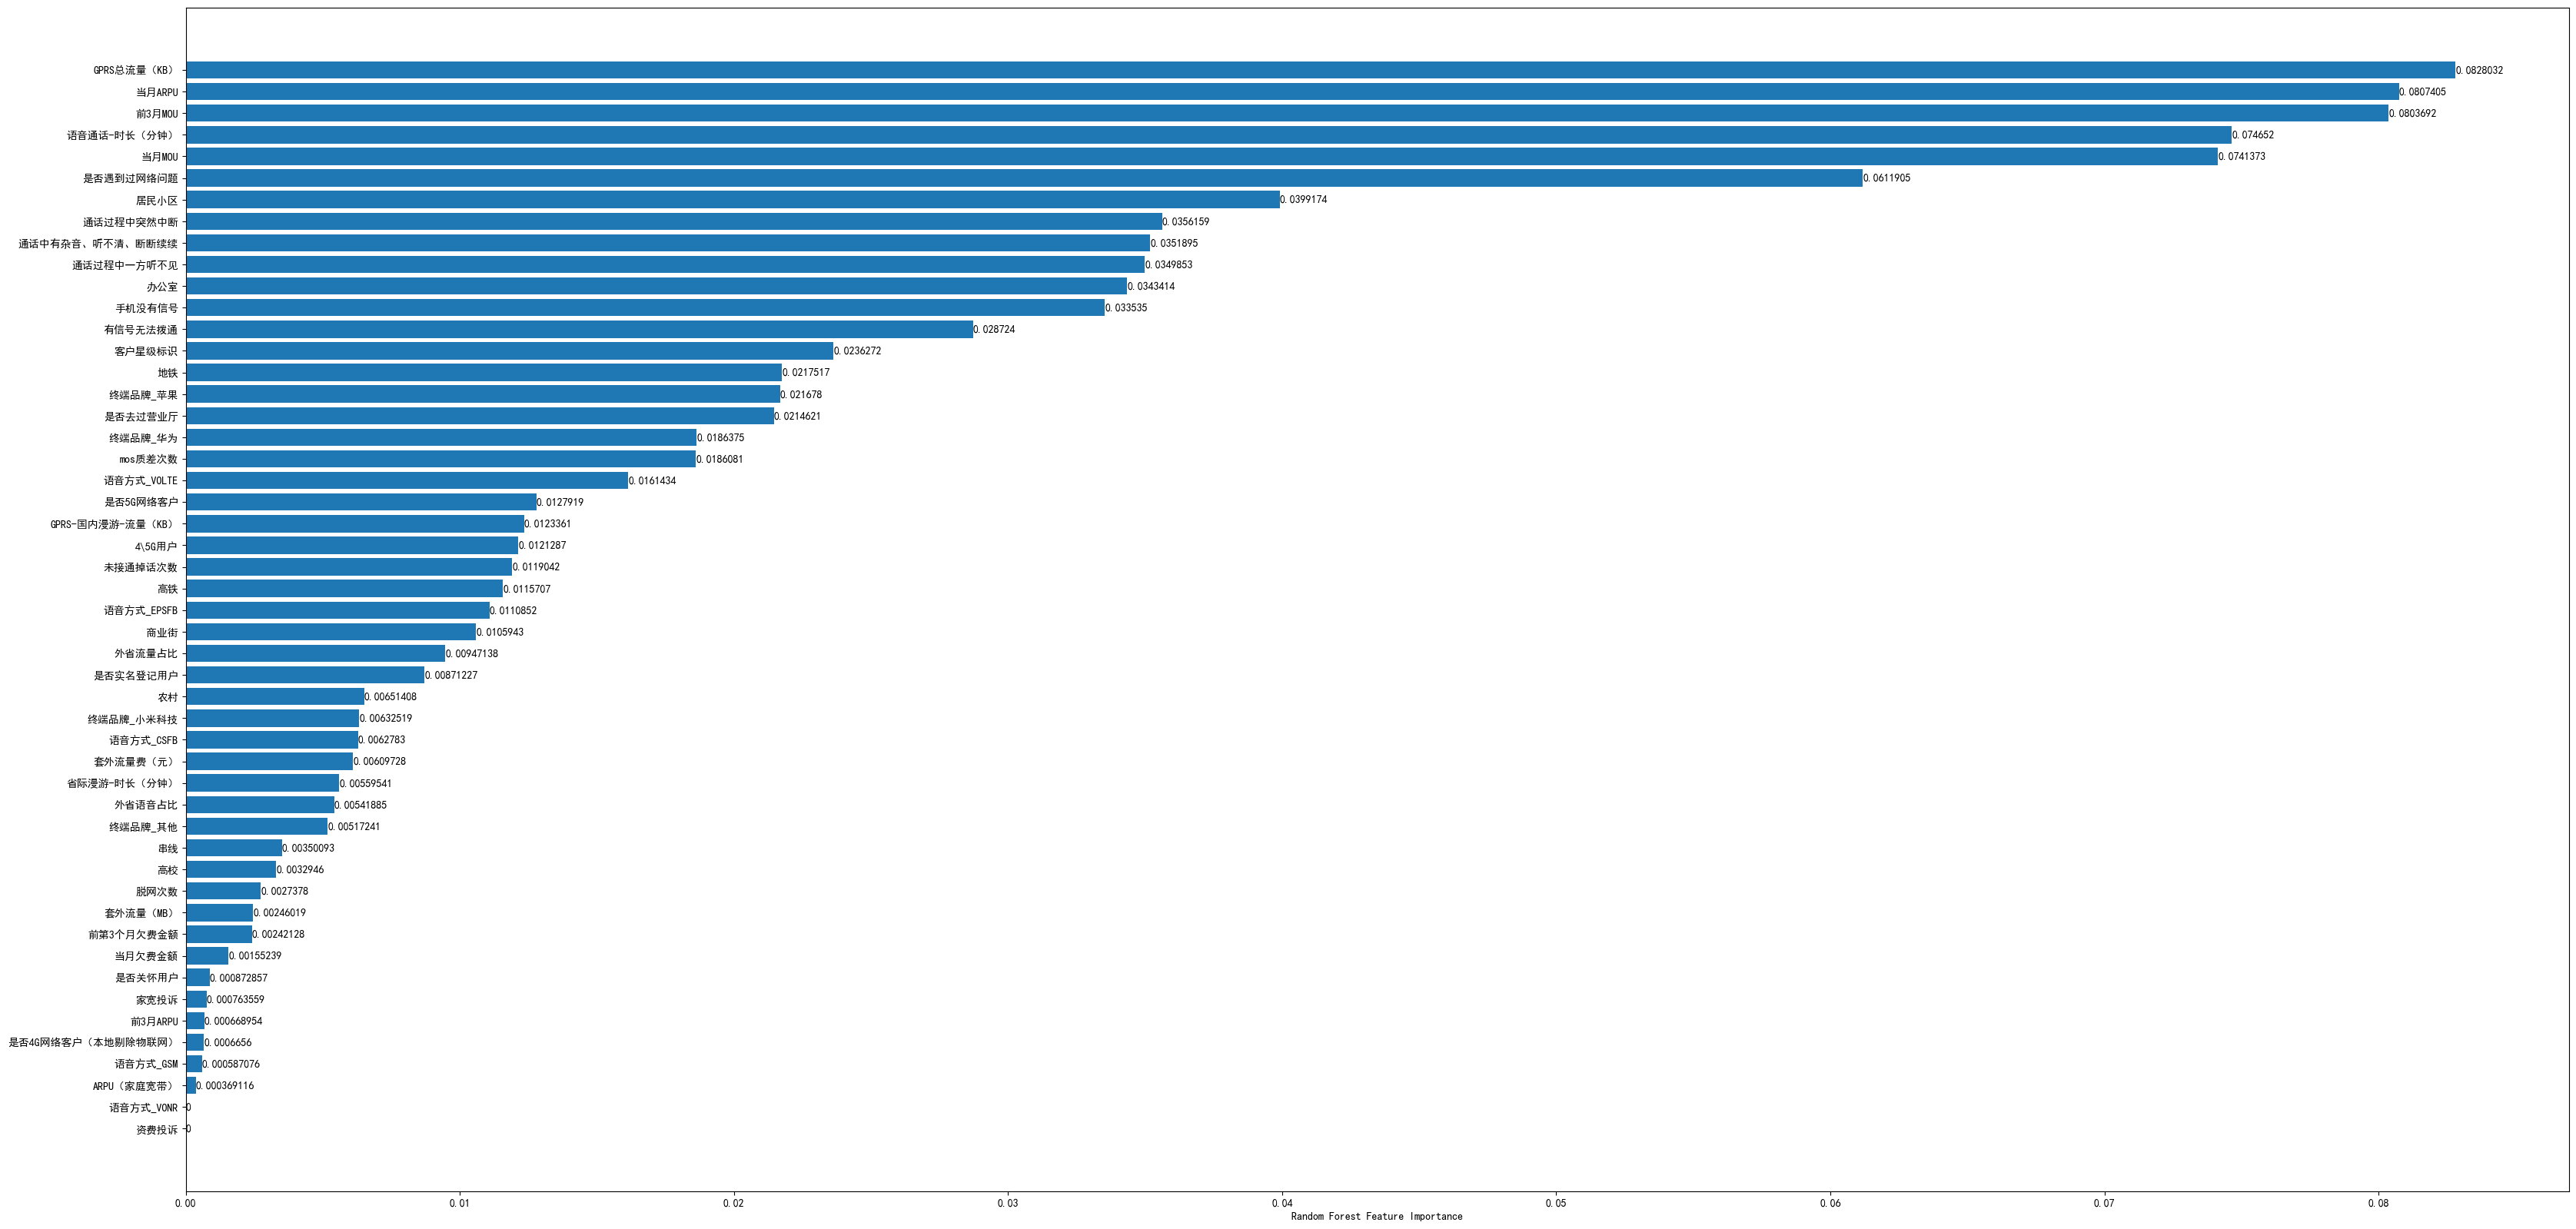

In [ ]:
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

In [ ]:
y0 = y0-1
v_y0 = v_y0-1

In [ ]:
# lgb-54
train_matrix = lightgbm.Dataset(x, y0)
test_matrix = lightgbm.Dataset(v_x, v_y0)
params = {
    'objective': 'multiclass',
    'num_class': 10,
    'min_data_in_leaf': 5,
    'num_leaves': 255,
    'matric': 'multi_error',
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'learning_rate': 0.03,
    'seed': 2023
}
num_round = 200
early_stopping_rounds = 100
model = lightgbm.train(
    params,
    train_matrix, num_round
)

y0_pred = model.predict(v_x)


[LightGBM] [Warning] Unknown parameter: matric
[LightGBM] [Warning] Unknown parameter: matric
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 49
[LightGBM] [Info] Start training from score -3.250374
[LightGBM] [Info] Start training from score -4.770200
[LightGBM] [Info] Start training from score -4.282497
[LightGBM] [Info] Start training from score -4.714630
[LightGBM] [Info] Start training from score -3.521527
[LightGBM] [Info] Start training from score -3.383906
[LightGBM] [Info] Start training from score -3.275692
[LightGBM] [Info] Start training from score -2.234238
[LightGBM] [Info] Start training from score -1.953936
[LightGBM] [Info] Start training from score -0.544827
[LightGBM] 

In [ ]:
y0_pred = [np.argmax(line) for line in y0_pred]
accuracy_score(v_y0, y0_pred)

0.5807692307692308

In [ ]:
y0 = y0+1
v_y0 = v_y0+1

In [ ]:
# xgb-54
y0 = y0-1
v_y0 = v_y0-1

In [ ]:
model = XGBClassifier().fit(x, y0)
y0_pred = model.predict(v_x)
accuracy_score(v_y0, y0_pred)

0.5684615384615385

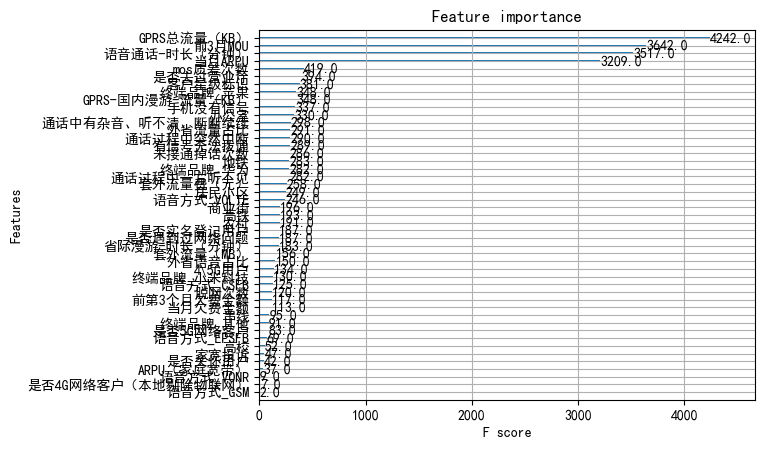

In [ ]:
plot_importance(model)
plt.show()

In [ ]:
y0 = y0+1
v_y0 = v_y0+1

- 特征工程

In [ ]:
# 生成排除线性相关变量后的数据集train_1
train_1=train.drop(labels=['前3月MOU','语音通话-时长（分钟）',
'外省流量占比','外省语音占比','省际漫游-时长（分钟）',
'前第3个月欠费金额',
'套外流量费（元）',
'前3月ARPU',
'家宽投诉','资费投诉',],axis=1)

In [ ]:
# 切分训练验证 x y
verify = train_1.sample(n=1500, replace=False)
trn = train_1.drop(verify.index)
x, y0, y1, y2, y3 = x_y_split(trn)
v_x, v_y0, v_y1, v_y2, v_y3 = x_y_split(verify)
# RF-42
for i in range(4):
    rfc = RandomForestClassifier(criterion='entropy',min_samples_leaf=5,min_samples_split=5,bootstrap=1,oob_score=1)
    rfc.fit(x, y0)
    print(f'第{i}次测试：')
    print('Training Accuracy : ',accuracy_score(y0, rfc.predict(x))*100)
    print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_x))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)


第0次测试：
Training Accuracy :  67.4643584521385
Validation Accuracy :  58.666666666666664
out-of-bagging Accuracy: 58.91038696537678
第1次测试：
Training Accuracy :  67.13340122199592
Validation Accuracy :  58.06666666666666
out-of-bagging Accuracy: 58.83401221995926
第2次测试：
Training Accuracy :  67.15885947046843
Validation Accuracy :  58.266666666666666
out-of-bagging Accuracy: 58.45213849287168
第3次测试：
Training Accuracy :  67.66802443991853
Validation Accuracy :  58.13333333333334
out-of-bagging Accuracy: 58.65580448065173


In [ ]:
# sorted_idx = rfc.feature_importances_.argsort()
# plt.figure(figsize=(40,20))
# p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
# plt.bar_label(p)
# plt.xlabel("Random Forest Feature Importance")

In [ ]:
# 使用三分项拟合整体满意度
# y = pd.concat([y1,y2,y3],axis=1)
# v_y = pd.concat([v_y1, v_y2, v_y3], axis=1)
# for i in range(4):
#     rfc = RandomForestClassifier(criterion='gini')
#     rfc.fit(y, y0)
#     print('Training Accuracy : ',accuracy_score(y0, rfc.predict(y))*100)
#     print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_y))*100)


In [ ]:
# x --> y1,y2,y3 --> y0
# y_pred = []
# for i in range(1,4):
#     rfc = RandomForestClassifier().fit(x,eval(f'y{i}'))
#     y_pred.append(rfc.predict(v_x))
#     score = accuracy_score(eval(f'v_y{i}'), y_pred[i-1])
#     print('score: ',score)


In [ ]:
# y_pred.append(rfc.predict(np.array(y_pred).T))
# accuracy_score(v_y0, y_pred[3])

- 特征衍生

In [ ]:
train_2 = train_1.drop(['语音方式_GSM','语音方式_VONR','是否4G网络客户（本地剔除物联网）'], axis=1)

In [ ]:
# 构建三大分项特征
train_2['网络覆盖范围问题次数']=train_2['居民小区']+train_2['办公室']+train_2['高校']+train_2['商业街']+train_2['地铁']+train_2['农村']+train_2['高铁']
train_2['信号强度问题次数']=train_2['有信号无法拨通']+train_2['手机没有信号']+train_2['脱网次数']
train_2['通话清晰度问题次数']=train_2['通话中有杂音、听不清、断断续续']+train_2['通话过程中一方听不见']+train_2['mos质差次数']
train_2['通话稳定性问题次数']=train_2['通话过程中突然中断']+train_2['串线']+train_2['未接通掉话次数']

In [ ]:
# 切分训练验证 x y
verify = train_2.sample(n=1500, replace=False)
trn = train_2.drop(verify.index)
x, y0, y1, y2, y3 = x_y_split(trn)
v_x, v_y0, v_y1, v_y2, v_y3 = x_y_split(verify)

# RF-42
for i in range(4):
    rfc = RandomForestClassifier(criterion='entropy',min_samples_leaf=5,min_samples_split=5,bootstrap=1,oob_score=1)
    rfc.fit(x, y0)
    print('Training Accuracy : ',accuracy_score(y0, rfc.predict(x))*100)
    print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_x))*100)
    print('out-of-bagging Accuracy:',rfc.oob_score_*100)

Training Accuracy :  68.55906313645622
Validation Accuracy :  58.53333333333334
out-of-bagging Accuracy: 58.63034623217923
Training Accuracy :  67.9989816700611
Validation Accuracy :  58.266666666666666
out-of-bagging Accuracy: 58.32484725050916
Training Accuracy :  68.38085539714868
Validation Accuracy :  58.53333333333334
out-of-bagging Accuracy: 58.27393075356415
Training Accuracy :  68.55906313645622
Validation Accuracy :  58.266666666666666
out-of-bagging Accuracy: 58.579429735234214


Text(0.5, 0, 'Random Forest Feature Importance')

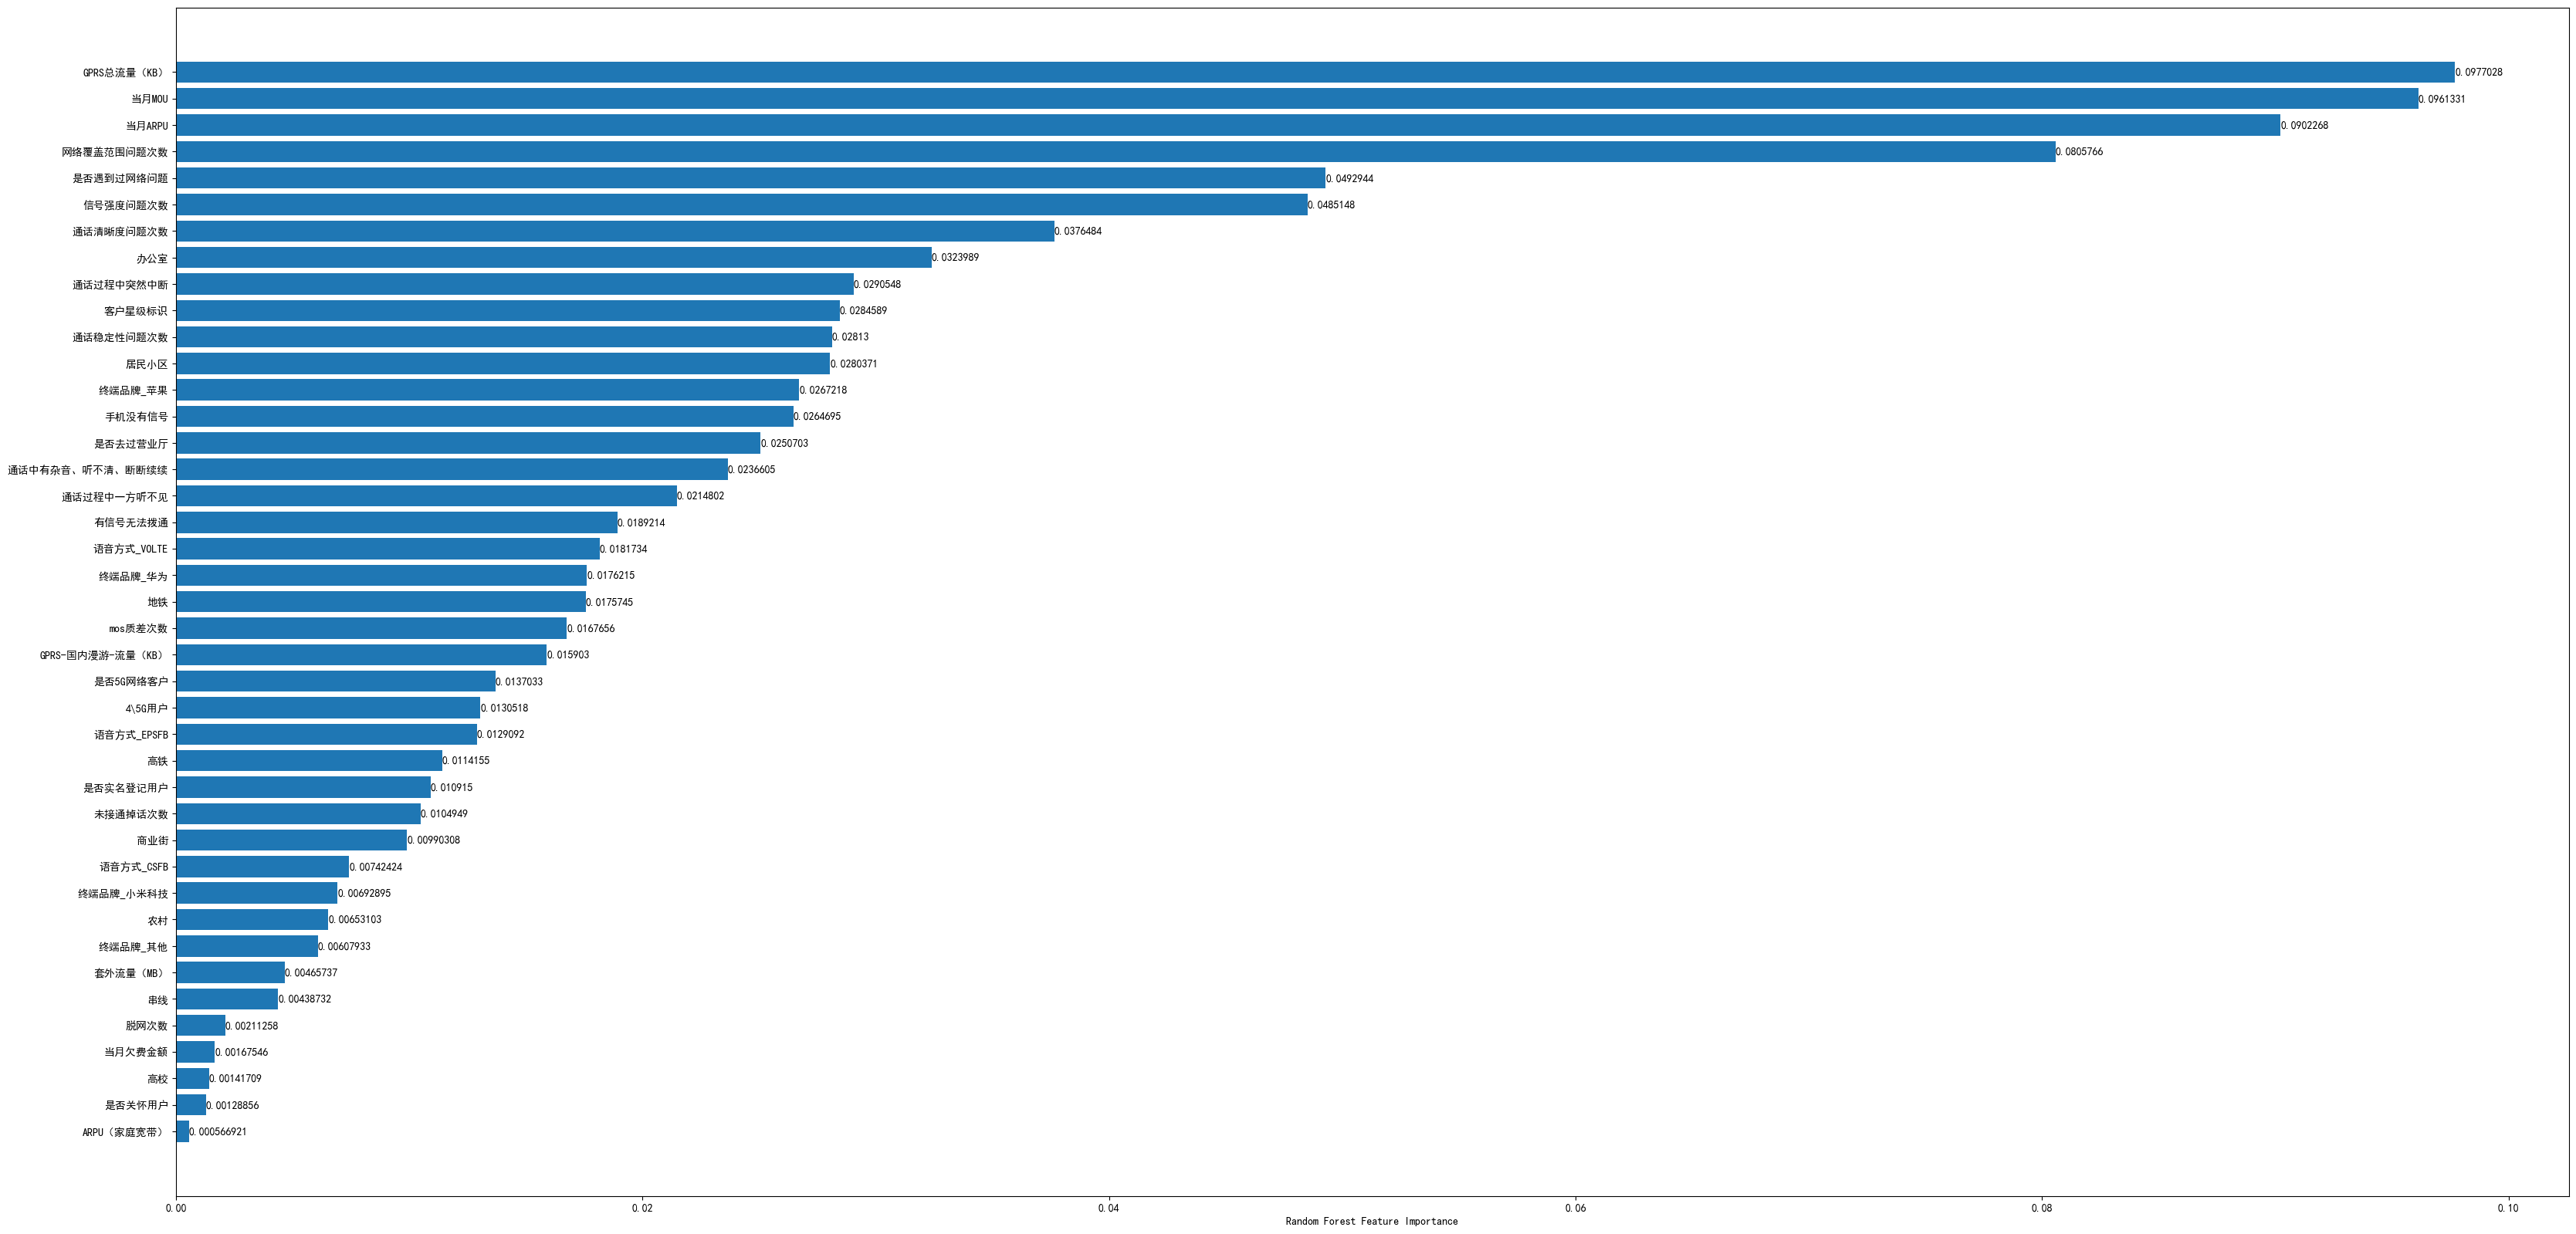

In [ ]:
sorted_idx = rfc.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(rfc.feature_names_in_[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# 构建客户特征
colname_sub = ['4\\5G用户', '是否关怀用户', '是否去过营业厅','是否5G网络客户', '是否实名登记用户', '客户星级标识']
numcols_sub = ['当月ARPU','套外流量（MB）','当月MOU', 'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）']
aggs = {}
for col in numcols_sub:
    aggs[col] = ['min','mean','max','std']


In [ ]:
aggs

{'当月ARPU': ['min', 'mean', 'max', 'std'],
 '套外流量（MB）': ['min', 'mean', 'max', 'std'],
 '当月MOU': ['min', 'mean', 'max', 'std'],
 'GPRS总流量（KB）': ['min', 'mean', 'max', 'std'],
 'GPRS-国内漫游-流量（KB）': ['min', 'mean', 'max', 'std']}

In [ ]:
# 添加新特征
for cate in colname_sub:
    cols_new = []
    cols_new.append(cate)
    for key in aggs.keys():
        cols_new.extend([key + '_' + cate + '_' + stat for stat in aggs[key]])

    new_feature = train_2.groupby(cate).agg(aggs).reset_index()
    new_feature.columns = cols_new
    train_1 = pd.merge(train_2, new_feature, how='left', on=cate)
    print(cate,'add finished!')

4\5G用户 add finished!
是否关怀用户 add finished!
是否去过营业厅 add finished!
是否5G网络客户 add finished!
是否实名登记用户 add finished!
客户星级标识 add finished!


In [ ]:
# 切分训练验证 x y
verify = train_2.sample(n=1500, replace=False)
trn = train_1.drop(verify.index)
x, y0, y1, y2, y3 = x_y_split(trn)
v_x, v_y0, v_y1, v_y2, v_y3 = x_y_split(verify)

# RF-42
for i in range(4):
    rfc = RandomForestClassifier(criterion='entropy',min_samples_leaf=5,min_samples_split=5,bootstrap=1,oob_score=1)
    rfc.fit(x, y0)
    print('Training Accuracy : ',accuracy_score(y0, rfc.predict(x))*100)
    print('Validation Accuracy : ',accuracy_score(v_y0, rfc.predict(v_x))*100)

Training Accuracy :  67.48981670061099


d:\Soft\Python\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- GPRS-国内漫游-流量（KB）_客户星级标识_max
- GPRS-国内漫游-流量（KB）_客户星级标识_mean
- GPRS-国内漫游-流量（KB）_客户星级标识_min
- GPRS-国内漫游-流量（KB）_客户星级标识_std
- GPRS总流量（KB）_客户星级标识_max
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 41 features, but RandomForestClassifier is expecting 61 features as input.

In [83]:
sorted_idx = rfc.feature_importances_.argsort()
num = rfc.feature_importances_[sorted_idx]
name = rfc.feature_names_in_[sorted_idx]

sel = {}
drop_list = []
for i,j in zip(name,num):
    if j>0.003:
        sel[i] = j
    else:
        drop_list.append(i)

train_2 = train_2.drop(drop_list,axis=1)


KeyError: "['GPRS-国内漫游-流量（KB）_客户星级标识_max', 'GPRS-国内漫游-流量（KB）_客户星级标识_min', 'GPRS总流量（KB）_客户星级标识_max', '当月ARPU_客户星级标识_max', '当月MOU_客户星级标识_max', '套外流量（MB）_客户星级标识_min', '套外流量（MB）_客户星级标识_max', 'GPRS总流量（KB）_客户星级标识_min', '当月ARPU_客户星级标识_min'] not found in axis"

- 参数优化

In [232]:
# #固定决策树数目，搜索最优的最大深度
# d_scores=[]
# for i in range(1,50):
#     RF=RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=i,random_state=0,n_jobs=4,class_weight='balanced')
#     RF.fit(x,y0)
#     d_scores.append(RF.score(v_x,v_y0))
# depth=d_scores.index(max(d_scores))
# print("最优树深度:",depth,"\n","准确度: ",max(d_scores),sep="")

In [233]:
# #按最优深度，搜锁最优决策树数目
# n_scores=[]
# for i in range(1,100):
#     RF=RandomForestClassifier(n_estimators=i,criterion="gini",max_depth=28,random_state=0, n_jobs=4,class_weight='balanced')
#     RF.fit(x,y0)
#     n_scores.append(RF.score(v_x,v_y0))
# sm=n_scores.index(max(n_scores))
# print("最优树数目",sm,"\n","准确度: ",max(n_scores),sep="")

In [234]:
# RFE
train_2.shape

(5428, 24)

In [227]:
rfc = RandomForestClassifier(criterion='entropy',min_samples_leaf=5,min_samples_split=5,bootstrap=1,oob_score=1)
rfe = RFE(estimator=rfc)
rfe.fit(x, y0)

RFE(estimator=RandomForestClassifier(bootstrap=1, criterion='entropy',
                                     min_samples_leaf=5, min_samples_split=5,
                                     oob_score=1))

In [228]:
drop_list = rfe.feature_names_in_[~rfe.get_support()]
train_2 = train_2.drop(drop_list,axis=1)
train_2.shape

(5428, 24)

In [243]:
# 网格调参
from sklearn.model_selection import GridSearchCV
params = {
    'criterion' : ["gini",'entropy'],
    'min_samples_leaf': range(1,11,3),
    'min_samples_split' : range(1,11,3),
    'max_depth': range(5,16,5),
    'max_samples': ['None',0.5,0.7,0.9],
    'max_features': ["sqrt",'log2',2,4,6],
    'n_estimators': range(10,160,70)
    
}


rfc_0 = RandomForestClassifier(random_state=1)
grid_rfc_0 = GridSearchCV(rfc_0, params, n_jobs=-1)
grid_rfc_0.fit(x, y0)

d:\Soft\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12600 fits failed out of a total of 28800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7200 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Soft\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Soft\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 389, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "d:\Soft\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 125, in _get_n_samples_bootstrap
    raise TypeError(msg.format(type(max_samples)))
TypeError: `max_sample

GridSearchCV(estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 16, 5),
                         'max_features': ['sqrt', 'log2', 2, 4, 6],
                         'max_samples': ['None', 0.5, 0.7, 0.9],
                         'min_samples_leaf': range(1, 11, 3),
                         'min_samples_split': range(1, 11, 3),
                         'n_estimators': range(10, 160, 70)})

In [246]:
grid_rfc_0.best_score_

0.5926691625743504

In [247]:
grid_rfc_0.best_estimator_

RandomForestClassifier(max_depth=15, max_samples=0.7, min_samples_leaf=10,
                       min_samples_split=4, n_estimators=80, random_state=1)